# TP Advanced machine learning : Part I

In [4]:
!wget http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
!unzip criteo-ppml-challenge-adkdd21-dataset.zip
!rm aggregated_noisy_data_pairs.csv.gz aggregated_noisy_data_singles.csv.gz  
!gunzip X_test.csv.gz X_train.csv.gz y_test.csv.gz y_train.csv.gz
!rm criteo-ppml-challenge-adkdd21-dataset.zip
!sed -n 1,10000p X_test.csv > X_valid.csv #CARE we took 10k lines from test as validation.
!sed -n 1,10000p y_test.csv > y_valid.csv

--2022-01-14 14:33:43--  http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving go.criteo.net (go.criteo.net)... 178.250.0.152
Connecting to go.criteo.net (go.criteo.net)|178.250.0.152|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip [following]
--2022-01-14 14:33:44--  https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo_ppml_challenge_adkdd2021/criteo-ppml-challenge-adkdd21-dataset.zip
Resolving criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)... 20.209.1.1
Connecting to criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)|20.209.1.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297834690 (284M) [application/zip]
Saving to: ‘criteo-ppml-challenge-adkdd21-dataset.zip’

criteo-ppml-challen 100%[=========

## Answer question 1 : 

To answer that question we introduce the matrix ```v``` that has a ```(D,K)``` shape. After that we modified the ```get_p``` and ```update_w``` functions : 
- ```get_p_factorization``` know that into account the $\sum_{i=1}^{n}\sum_{j=i+1}^{n} x_i x_j v_{i, j}$ part.
- ```update_wL2_factorization``` update the values for the matrix ```v``` with an L2 regularization. For the matrix ```v``` terms we use the partial derivative for $v_{i,f}$ of the matrix ```v``` given by $x_{i} \sum_{j=1}^{n} v_{j, f} x_{j}-v_{i, f} x_{i}^{2}$ 

In [21]:
# ANSWER - same stuff with a L2 regularizer (bias term + quad terms)
# A lot of settings allows a large difference between train and validation, theses are indeed bad
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt


# ANSWER with ony one vector for parameters. This is also possible to split the first and second order terms
def get_x(csv_row, D):
    """
    Apply hash trick for the original csv row
    :param csv_row: csv dictionnary ex : {'hash_1': '357', 'hash_2': '', ...}
    :param D:int: max index that we can hash
    :return : list: return a list of indices to find the corresponding weights.
    """
    # TODO : optimiser en numpy 
    x = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D
        x.append(index)
    x.append(0)
    return x


def logloss(p, y):
    """
    :param p:float:prediction of a model
    :param y:int: real answer
    """
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

def compute_validation_loss_factorization(w, D, v, k):
    """
    Function that computes to the loss for the fatorization machine method
    :param w: list : weights 
    :param D: int : number of weights possible 
    :param v: numpy ndarray :factorization matrix
    :param k: int: number of factors
    
    """
    val_loss = 0
    for t, (row, y) in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
        x = get_x(row, D)
        p = get_p_factorization(x, w, v, k)
        target = float(y['click'])
        val_loss += logloss(p, target)
    return val_loss / t


def get_p_factorization(x, w, v, k):
    """ Function that return the prediction given the parameter of the model
    :param x : list : list of indices to map the weights
    :param w : list of the weights
    :param v : factorization matrix of shape (D,K)
    :param k : int : number of factors for K"""
    wTx = 0.
    for i in x:
        # wTx
        wTx += w[i] * 1.  # w[i] * 1

    # TODO : documenter cette partie
    for f in range(k):
        sv = np.sum(v[x, f] * 1) ** 2
        wTx += 0.5 * (sv - np.sum(v[x, f] ** 2 * 1))

    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


def update_wL2_factorization(w, v, n, x, p, y, k, lbd=5e-4, alpha=.01):
    """Function that upadtes the weights with a gradient descent
    :param w:list of weights
    :param v:numpy array : factorization matrix
    :param n:list mapping how many times we updated a weight
    :param x:list: list of indices
    :param p: prediction of the model
    :param y: label value
    :param k: int : number of factors
    :param lbd: float : L2 regularization
    :param alpha: float : learning rate"""
    for index, value in enumerate(x):
        # Update w 
        w[value] -= ((p - y) + lbd * 2 * w[value]) * alpha / (sqrt(n[value]) + 1.)
        n[value] += 1.
    # Update v with L2 regularization
    for f in range(k):
        sv = np.sum(v[x, f])
        for index, value in enumerate(x):
            v[value, f] -= ((p - y) * (sv - v[value, f]) + lbd * 2 * v[value, f]) * alpha
    return w, v, n


We define the basic terms 

In [50]:
D = 2 ** 24
w, n  = [0.] * D , [0.] * D
loss = 0.
n_epochs, n_updates = 5, 0
training_losses, validation_losses = [], []
alpha = .01 
k=5


X_train = 'X_train.csv' 
y_train = 'y_train.csv'
X_valid = 'X_valid.csv'
y_valid = 'y_valid.csv'


We then initialize the factors matrix ```v```

In [51]:
v = np.full(shape = (D, k), fill_value = -0.01)

For the number of epochs defined we train the model. We gather the ```training_loss``` and the ```validation_loss```

In [52]:
for e in range(n_epochs):
    training_loss = 0
    for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
        x = get_x(row, D)  # I gather the memory placement of the coefficients
        p = get_p_factorization(x, w, v, k) # I gather the prediction
        target = float(y['click'])
        training_loss += logloss(p, target) # I compare my model
        if n_updates% 20000 == 0 and n_updates>1:
            training_losses.append( training_loss/t )
            validation_losses.append( compute_validation_loss_factorization(w, D, v, k) )
            print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f' % (
                datetime.now(), n_updates, training_losses[-1], validation_losses[-1] ))
        w, v, n = update_wL2_factorization(w, v, n, x, p, target, k) # Update the coefficients
        n_updates += 1
        
wL2 = w #keep it for later use

#Depending on the learning rate and the coefficent in front of regularization this is possible 
#to have some overfitting advocating for early stopping. Remark that it does not hurt as hard the validation performance 
#Gains remains quite unclear, possibly due to the small dataset size   

2022-01-14 15:14:04.202003	updates: 10000	current logloss on train: 0.317943	current logloss on validation: 0.271122
2022-01-14 15:14:10.349707	updates: 20000	current logloss on train: 0.286493	current logloss on validation: 0.267589
2022-01-14 15:14:16.421620	updates: 30000	current logloss on train: 0.275874	current logloss on validation: 0.260774
2022-01-14 15:14:22.476577	updates: 40000	current logloss on train: 0.274641	current logloss on validation: 0.262019
2022-01-14 15:14:28.542293	updates: 50000	current logloss on train: 0.273379	current logloss on validation: 0.263118
2022-01-14 15:14:34.550048	updates: 60000	current logloss on train: 0.272494	current logloss on validation: 0.261211
2022-01-14 15:14:40.674296	updates: 70000	current logloss on train: 0.271630	current logloss on validation: 0.258145
2022-01-14 15:14:46.827576	updates: 80000	current logloss on train: 0.269361	current logloss on validation: 0.258261
2022-01-14 15:14:52.980642	updates: 90000	current logloss on tra

We plot the result : 

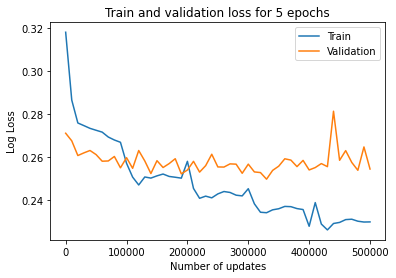

In [53]:
x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend(('Train', 'Validation'))
plt.title(f'Train and validation loss for {n_epochs} epochs')
plt.show()

## Interpretation

# Answer question 2

In [55]:
import numpy as np
X_train = np.loadtxt('X_train.csv', skiprows=1, delimiter=',')
X_train = [[('%s' % _, 1) for _ in x] for x in X_train][10000:] #Data format expected by the Feature Hasher is a sequence of key,value

In [56]:
X_test = 'X_test.csv'
y_test = 'y_test_csv'

!sed -n 1,50000p X_test.csv > X_opt.csv #CARE we took 10k lines from test as validation.
!sed -n 1,50000p y_test.csv > y_opt.csv
X_opt = 'X_opt.csv'
y_opt = 'y_opt.csv'

In [57]:
!head X_opt.csv

hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9,hash_10,hash_11,hash_12,hash_13,hash_14,hash_15,hash_16,hash_17,hash_18
187652,199446,480789,-84947,-419788,-356697,-73473,-201336,336272,39558,171177,-332795,-197733,-102727,-267888,-324676,172595,-1100,182002
-196263,-137304,480789,-428062,347621,-310777,220982,-201336,336272,301505,406906,-265634,467836,-437971,26095,-328942,-400942,-429456,346045
-216157,-137304,480789,-428062,347621,-310777,167271,-201336,359042,-311089,306285,-332795,-283182,-102727,495950,-324676,326477,-317260,182002
11652,-432181,480789,-169356,287595,-310777,-332084,-201336,310671,409356,-496385,-332795,236957,-102727,-20670,-324676,-153563,258932,-124383
224181,-455384,313949,-428062,166559,-310777,167271,-201336,127803,409356,-23318,-332795,286937,35444,335698,-324676,132133,-355723,-124383
486387,-432181,480789,-169356,-419788,-356697,-484965,-201336,-428527,-139213,25441,-468602,315199,-102727,-421972,-241726,306269,-271996,346045
44209

We install wandb in our machine.

In [59]:
# !pip install wandb
# !wandb login

We define the range of the parameters we want to optimize.

In [ ]:
import wandb
sweep_config = {
  "name" : "TP1-ENSAE-hyperparameter_search",
  "method" : "random", #There exist several strategies such as Bayes and it possible to add some early stopping (see Hyperband). Care NCE is not a loss (higher is better)
  "parameters" : {
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    },
    "l2":{
      "min": 0.,
      "max": 0.1
    },
    "k":{
      "min": 2,
      "max": 20
    },
  }
}
sweep_id = wandb.sweep(sweep_config)

In [ ]:
import wandb
sweep_config = {
  "name" : "TP1-ENSAE-hyperparameter_search",
  "method" : "random", #There exist several strategies such as Bayes and it possible to add some early stopping (see Hyperband). Care NCE is not a loss (higher is better)
  "parameters" : {
    "k":{
      "min": 2,
      "max": 20
    },
  }
}
sweep_id = wandb.sweep(sweep_config)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········


wandb: ERROR API key must be 40 characters long, yours was 8
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


In [ ]:
def train():
    with wandb.init(reinit=True) as run:
        config = wandb.config
        D = 2 ** 24
        w = [0.] * D  
        n = [0.] * D
        alpha = .01
        n_epochs = 1
        loss = 0.
        n_updates = 0
        v = np.full(shape = (D, config['k']), fill_value = -0.1)

    for e in range(n_epochs):
        for t, (row, y)  in enumerate(zip(DictReader(open(X_opt)), DictReader(open(y_opt)))):
            x = get_x(row, D)
            p = get_p_factorization(x, w, v, config['k'])
            target = float(y['click'])
            if n_updates% 10000 == 0 and n_updates>1:
                wandb.log({"loss": compute_validation_loss_factorization(w, D, v, config['k']),
                         "epoch": e,"n_updates":n_updates})
            w, v, n = update_wL2_factorization(w, v, n, x, p, target, config['k'])  
            n_updates += 1

count = 10 #Indeed the more the better and longer
#Using the same sweep_id it is also possible to distribute the training
wandb.agent(sweep_id, function=train, count=count) 